In [1]:
#Importing libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

#tensorflow libraries
import tensorflow as tf
from keras.applications import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Loading Dataset

In [2]:
path = "animals"

data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)

df = pd.DataFrame(data) 

path: เส้นทางไปยังโฟลเดอร์ที่มีภาพของสัตว์

data: สร้าง dictionary เพื่อเก็บที่อยู่ภาพ (imgpath) และชื่อคลาส (labels)

os.listdir(path): ดึงรายชื่อโฟลเดอร์ในโฟลเดอร์ที่ระบุ

ข้อมูลในโฟลเดอร์จะถูกเพิ่มลงใน DataFrame df

## Split the Dataset into Train & Test

In [3]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#Removing old index columns
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

#Displaying train dataframe
print(train_df[["imgpath", "labels"]].head())

#Checking the shape of dataframe
print(train_df.shape)

                               imgpath        labels
0           animals\owl\4ee4d30847.jpg           owl
1   animals\caterpillar\89eeb3fb5a.jpg   caterpillar
2  animals\hippopotamus\5bbec0931a.jpg  hippopotamus
3           animals\bee\1cb123c4e9.jpg           bee
4          animals\hare\83ede67a4d.jpg          hare
(3779, 2)


train_test_split: ใช้เพื่อแบ่งข้อมูลออกเป็นชุดการฝึก (70%), การตรวจสอบ (20%), และการทดสอบ (10%)

reset_index: รีเซ็ต index ของ DataFrame

แสดงข้อมูล 5 แถวแรกจาก DataFrame การฝึก และตรวจสอบขนาดของ DataFrame

## Show sample from data

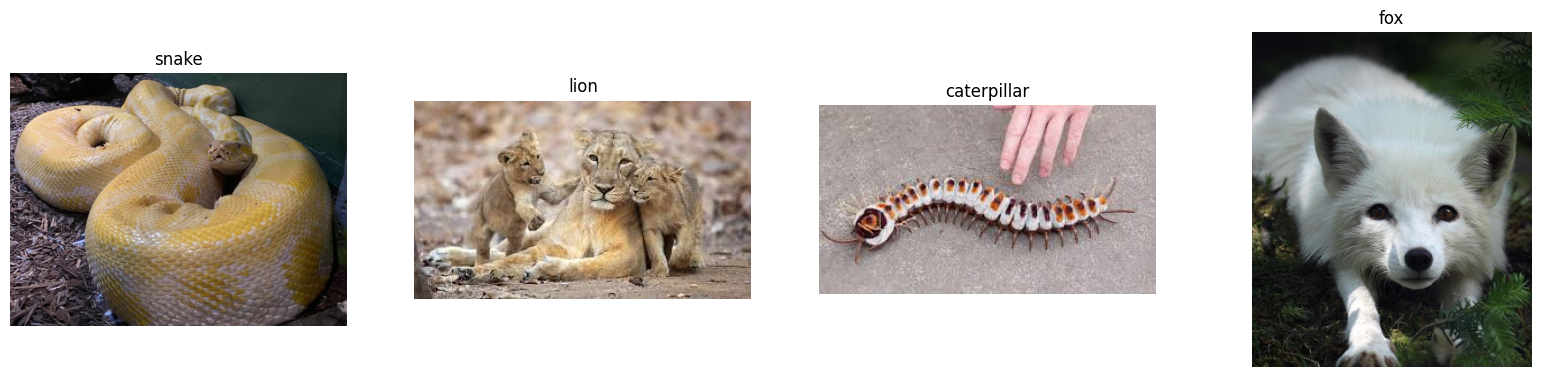

In [4]:
#Defining size of displayed image
plt.figure(figsize=(20,20))

#Displaying images from test dataframe
for i, row in test_df.sample(n=4).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

แสดงภาพตัวอย่าง 4 ภาพจากชุดข้อมูลการทดสอบ โดยใช้ matplotlib

## Creating Dataloaders

In [5]:
BATCH_SIZE = 16
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.


สร้าง ImageDataGenerator สำหรับการเตรียมภาพ ซึ่งรวมถึงการปรับขนาดและการแปลงภาพให้เหมาะสมกับ MobileNetV2

แบ่งข้อมูลเป็นชุดการฝึก, การตรวจสอบ, และการทดสอบ โดยใช้ flow_from_dataframe เพื่ออ่านข้อมูลจาก DataFrame

## Model Structure

In [6]:
# Load the pretained model
pretrained_mobilenet = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freezing the layers of a pretrained neural network
for layer in pretrained_mobilenet.layers:
    layer.trainable = False 

In [7]:
num_classes = len(set(train_images.classes))

# Build the new model
model_mobilenet = Sequential()
model_mobilenet.add(pretrained_mobilenet)
model_mobilenet.add(GlobalAveragePooling2D())
model_mobilenet.add(Dense(256, activation='relu'))
model_mobilenet.add(BatchNormalization())
model_mobilenet.add(Dropout(0.4))
model_mobilenet.add(Dense(num_classes, activation='softmax'))

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.load_weights('./checkpoints/my_checkpoint')

print(model_mobilenet.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

โหลด MobileNetV2 ที่ได้รับการฝึกมาแล้วและกำหนดให้ไม่สามารถปรับค่าของเลเยอร์ที่ได้รับการฝึกมาแล้ว

สร้างโมเดลใหม่โดยใช้ Sequential และเพิ่มเลเยอร์ที่ต้องการ:
* GlobalAveragePooling2D: ลดขนาดข้อมูล
* Dense(256, activation='relu'): เลเยอร์ fully connected ขนาด 256 units พร้อมฟังก์ชัน activation แบบ ReLU
* BatchNormalization(): ใช้ปรับสเกลและทำ normalization ของ output
* Dropout(0.4): ลด overfitting โดยสุ่มปิดการทำงานของ 40% ของ neurons ในเลเยอร์นี้ระหว่างการฝึกสอน
* Dense(num_classes, activation='softmax'): เลเยอร์สุดท้ายที่ใช้ Softmax สำหรับจำแนกผลลัพธ์ตามจำนวนคลาสทั้งหมดในข้อมูล

คอมไพล์โมเดลด้วยการกำหนด optimizer เป็น Adam ที่ learning rate = 0.0005 และ loss เป็น categorical_crossentrop

## Training

In [8]:
history_resnet = model_mobilenet.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

model_mobilenet.save_weights('./checkpoints/my_checkpoint1')

Epoch 1/20
237/237 [==============================] - 25s 98ms/step - loss: 2.5677 - accuracy: 0.4379 - val_loss: 1.0356 - val_accuracy: 0.7619 - lr: 5.0000e-04
Epoch 2/20
237/237 [==============================] - 19s 81ms/step - loss: 0.7877 - accuracy: 0.8206 - val_loss: 0.6949 - val_accuracy: 0.8245 - lr: 5.0000e-04
Epoch 3/20
237/237 [==============================] - 19s 81ms/step - loss: 0.4693 - accuracy: 0.8878 - val_loss: 0.6078 - val_accuracy: 0.8395 - lr: 5.0000e-04
Epoch 4/20
237/237 [==============================] - 21s 87ms/step - loss: 0.2808 - accuracy: 0.9436 - val_loss: 0.5538 - val_accuracy: 0.8448 - lr: 5.0000e-04
Epoch 5/20
237/237 [==============================] - 26s 111ms/step - loss: 0.1880 - accuracy: 0.9653 - val_loss: 0.5494 - val_accuracy: 0.8457 - lr: 5.0000e-04
Epoch 6/20
237/237 [==============================] - 24s 102ms/step - loss: 0.1385 - accuracy: 0.9741 - val_loss: 0.5226 - val_accuracy: 0.8554 - lr: 5.0000e-04
Epoch 7/20
237/237 [============

ฝึกโมเดลบนชุดข้อมูลการฝึกและตรวจสอบการทำงานบนชุดข้อมูลการตรวจสอบ

โดยเพิ่ม EarlyStopping เพื่อหยุดการฝึกสอนเมื่อ val_loss ไม่ลดลงภายใน 3 epochs และคืนค่า weight ที่ดีที่สุด และ ReduceLROnPlateau เพื่อลด learning rate เมื่อ val_loss ไม่ลดลงภายใน 2 epochs โดยลดเป็น 20%

## Display model performance

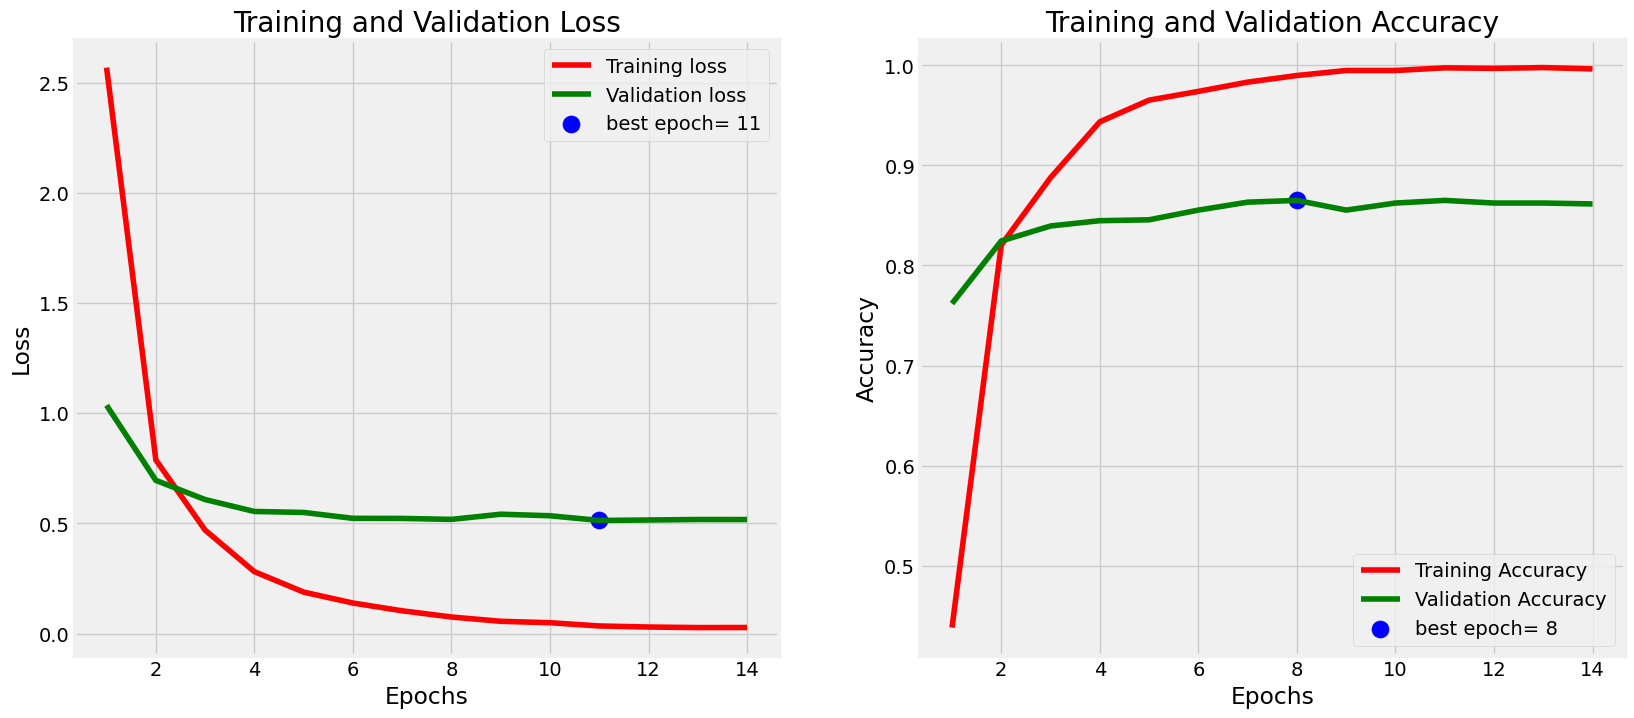

In [9]:
tr_acc = history_resnet.history['accuracy']
tr_loss = history_resnet.history['loss']
val_acc = history_resnet.history['val_accuracy']
val_loss = history_resnet.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

ดึงค่า Accuracy และ Loss จากการฝึกและการตรวจสอบ

แสดงกราฟการฝึกและการตรวจสอบเพื่อตรวจสอบการทำงานของโมเดล

In [10]:
results = model_mobilenet.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.46495
Test Accuracy: 87.68%


ใช้ evaluate เพื่อตรวจสอบ Loss และ Accuracy ของโมเดลในชุดข้อมูลทดสอบ

## Fine Tuning

In [11]:
n_freezes = 0

for layer in pretrained_mobilenet.layers[:n_freezes]:
    layer.trainable = False
for layer in pretrained_mobilenet.layers[n_freezes:]:
    layer.trainable = True
    if isinstance(layer, BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# model.load_weights('./checkpoints/my_checkpoint')

print(model_mobilenet.summary())

history = model_mobilenet.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min') 
    ]
)

model_mobilenet.save_weights('./checkpoints/my_checkpoint2')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

กำหนดเป็น trainable = True เพื่อให้สามารถปรับปรุงน้ำหนักระหว่างการฝึกสอน

ฝึกโมเดลตามเดิมโดย กำหนดให้ค่า learning rate มีค่าต่ำ (0.00001) เพื่อให้การอัปเดตน้ำหนักเกิดขึ้นอย่างค่อยเป็นค่อยไป

## Display model performance

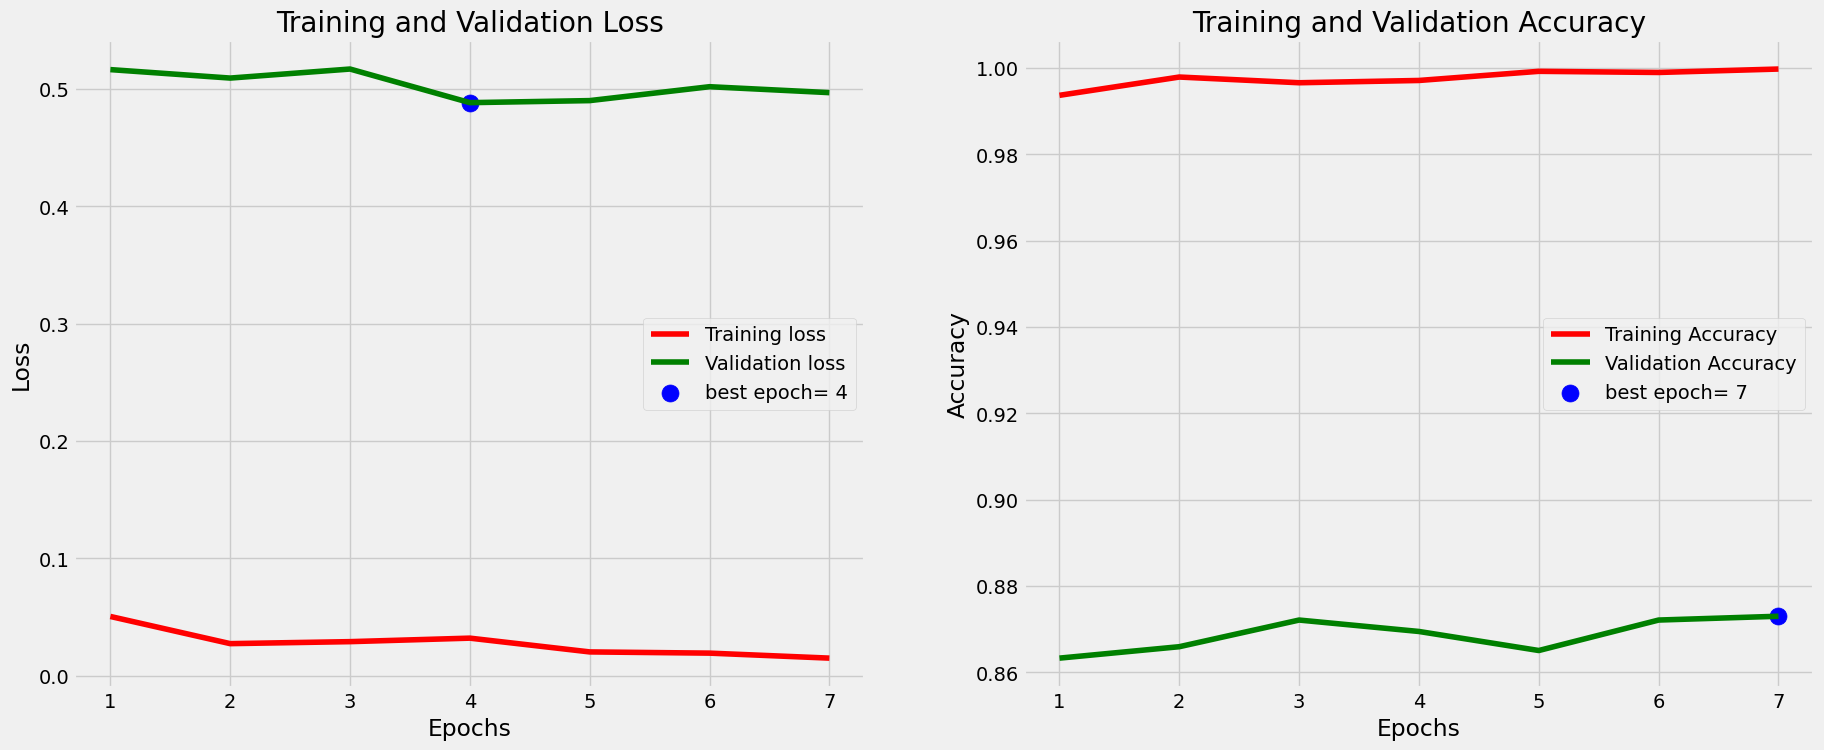

In [12]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

ดึงค่า Accuracy และ Loss จากการฝึกและการตรวจสอบ

แสดงกราฟการฝึกและการตรวจสอบเพื่อตรวจสอบการทำงานของโมเดล

In [13]:
results = model_mobilenet.evaluate(test_images, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.45172
Test Accuracy: 88.50%


ใช้ evaluate เพื่อตรวจสอบ Loss และ Accuracy ของโมเดลในชุดข้อมูลทดสอบ

In [14]:
# Save the model
model_mobilenet.save('animal_classification_model.h5')

## Get Predictions

In [15]:
y_pred = np.argmax(model_mobilenet.predict(test_images), axis = 1)

31/31 [==============================] - 2s 58ms/step


In [16]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))), 
                            "Test Labels" : test_images.labels, 
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model_mobilenet.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

31/31 [==============================] - 2s 59ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           76        snake                 76   
1            1           88   woodpecker                 88   
2            2            7         boar                  7   
3            3           83       turkey                 83   
4            4           63          pig                  7   
5            5           66       possum                 66   
6            6           34         hare                 34   
7            7           62      penguin                 62   

  Prediction Classes                               Path  \
0              snake       animals\snake\68fa005f8c.jpg   
1         woodpecker  animals\woodpecker\41bfce3808.jpg   
2               boar        animals\boar\0b2e935388.jpg   
3             turkey      animals\turkey\3d05120fc1.jpg   
4               boar         animals\pig\18cfa343b2.jpg   
5             possum      animals\possum\0d16effd0b.jpg   
6               hare        animals\hare\83b1c6bc53.jpg   
7            penguin     animals\penguin\62d0684ef7.jpg   

   Prediction Probability  
0                0.981555  
1                0.999871  
2                0.996020  
3                0.999982  
4                0.929932  
5                0.699190  
6                0.999711  
7                0.999752

## Print the most confident errors

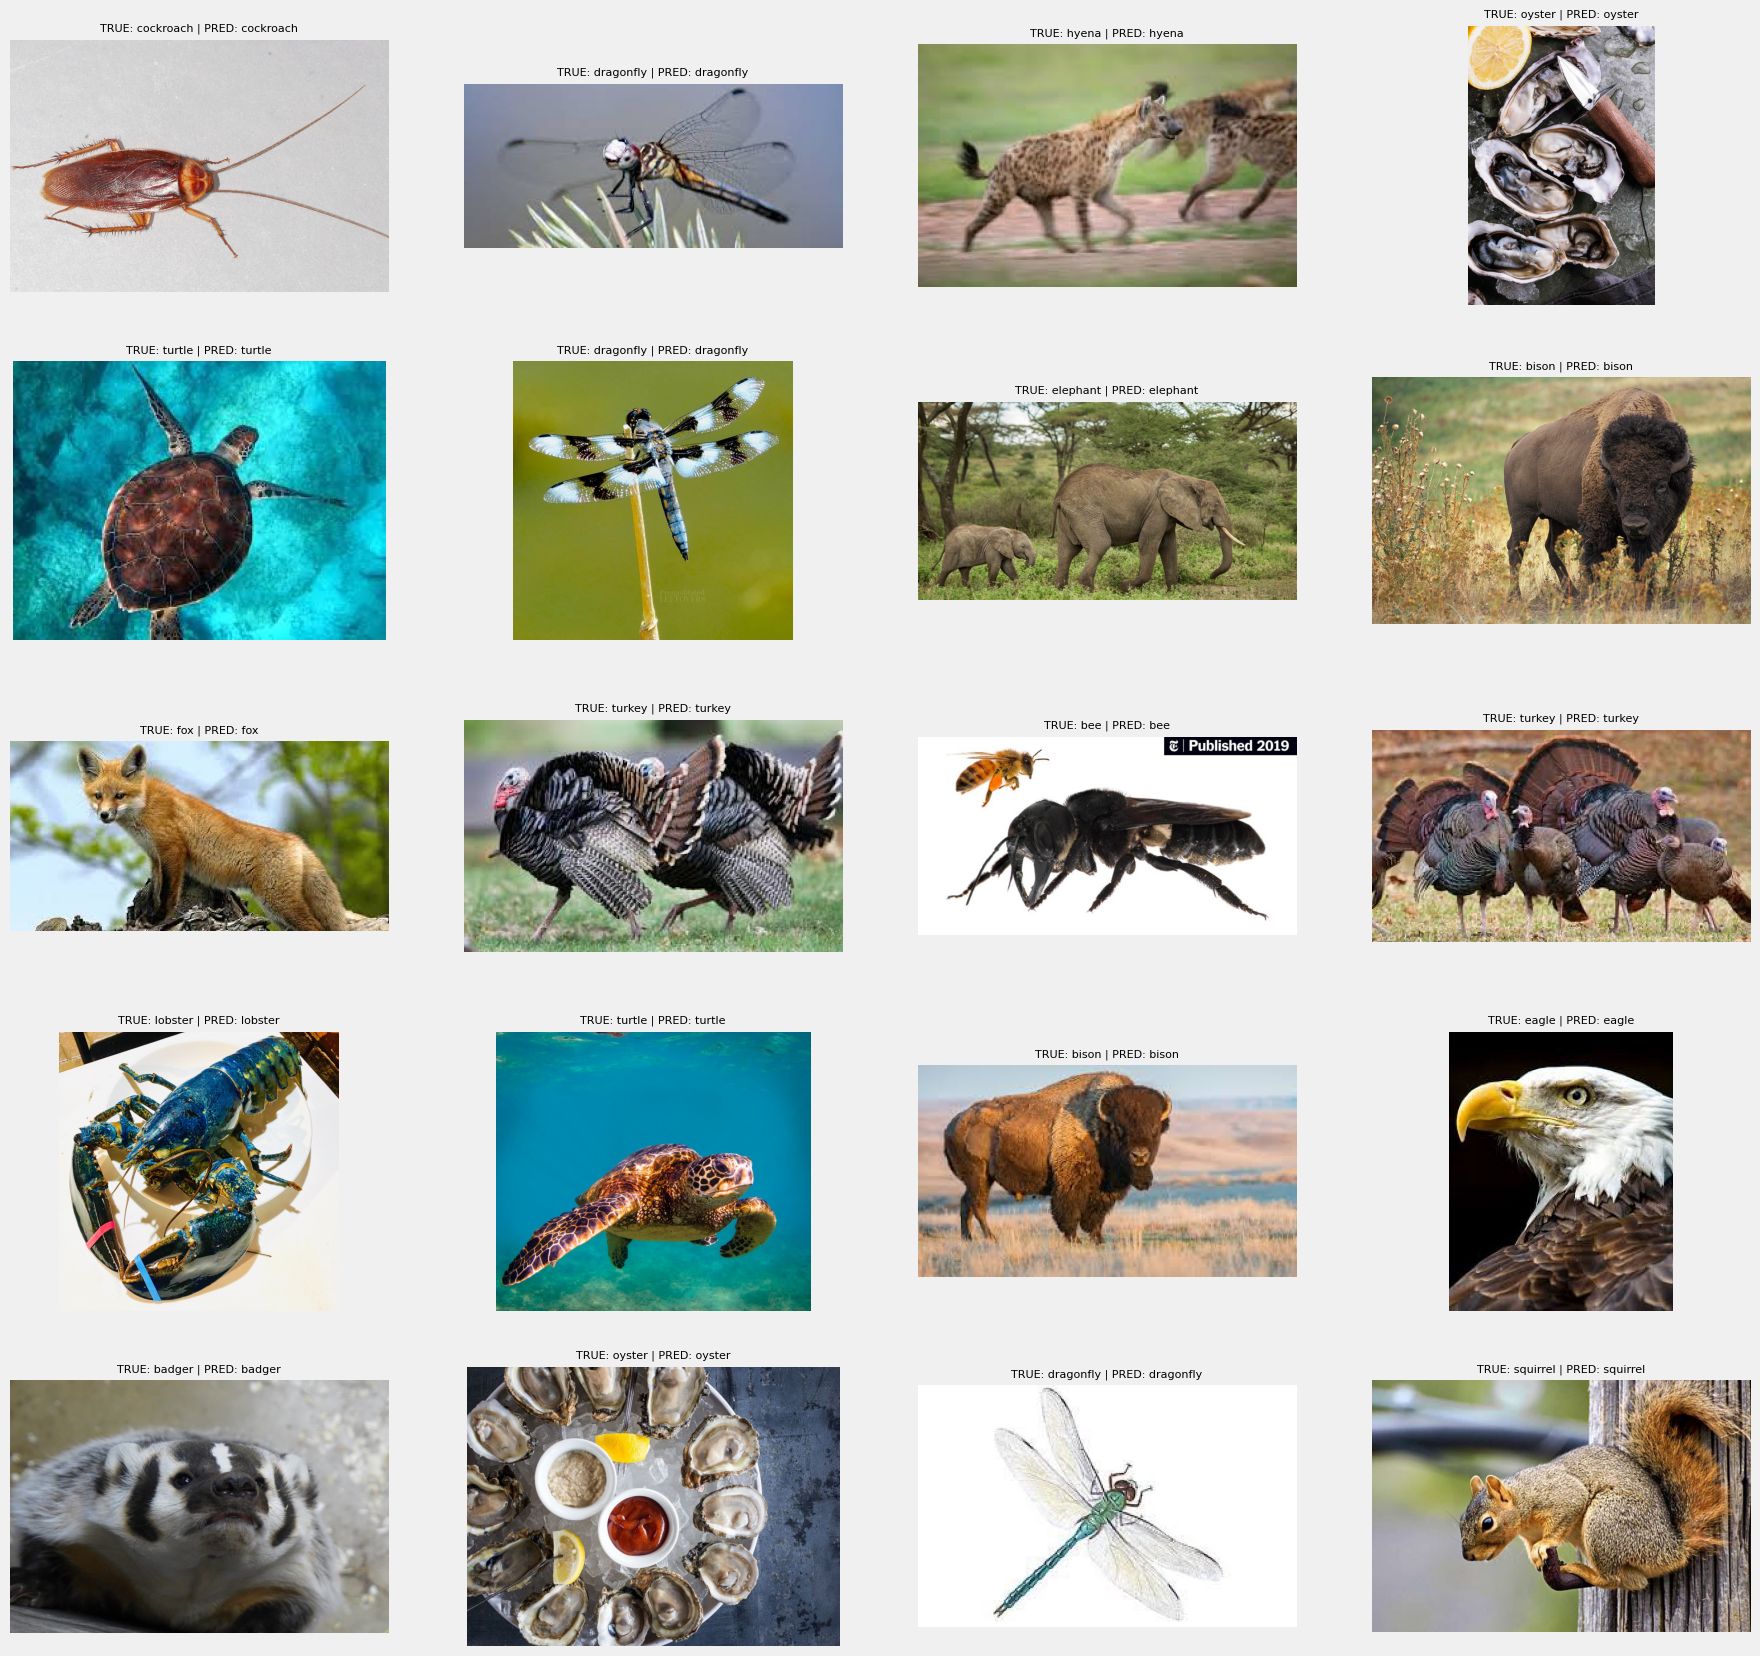

In [17]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] == Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

แสดงภาพตัวอย่าง 20 ภาพจากชุดข้อมูลการทดสอบ ซึ่งเป็นภาพที่มีการทำนายที่ถูกต้อง โดยใช้ matplotlib

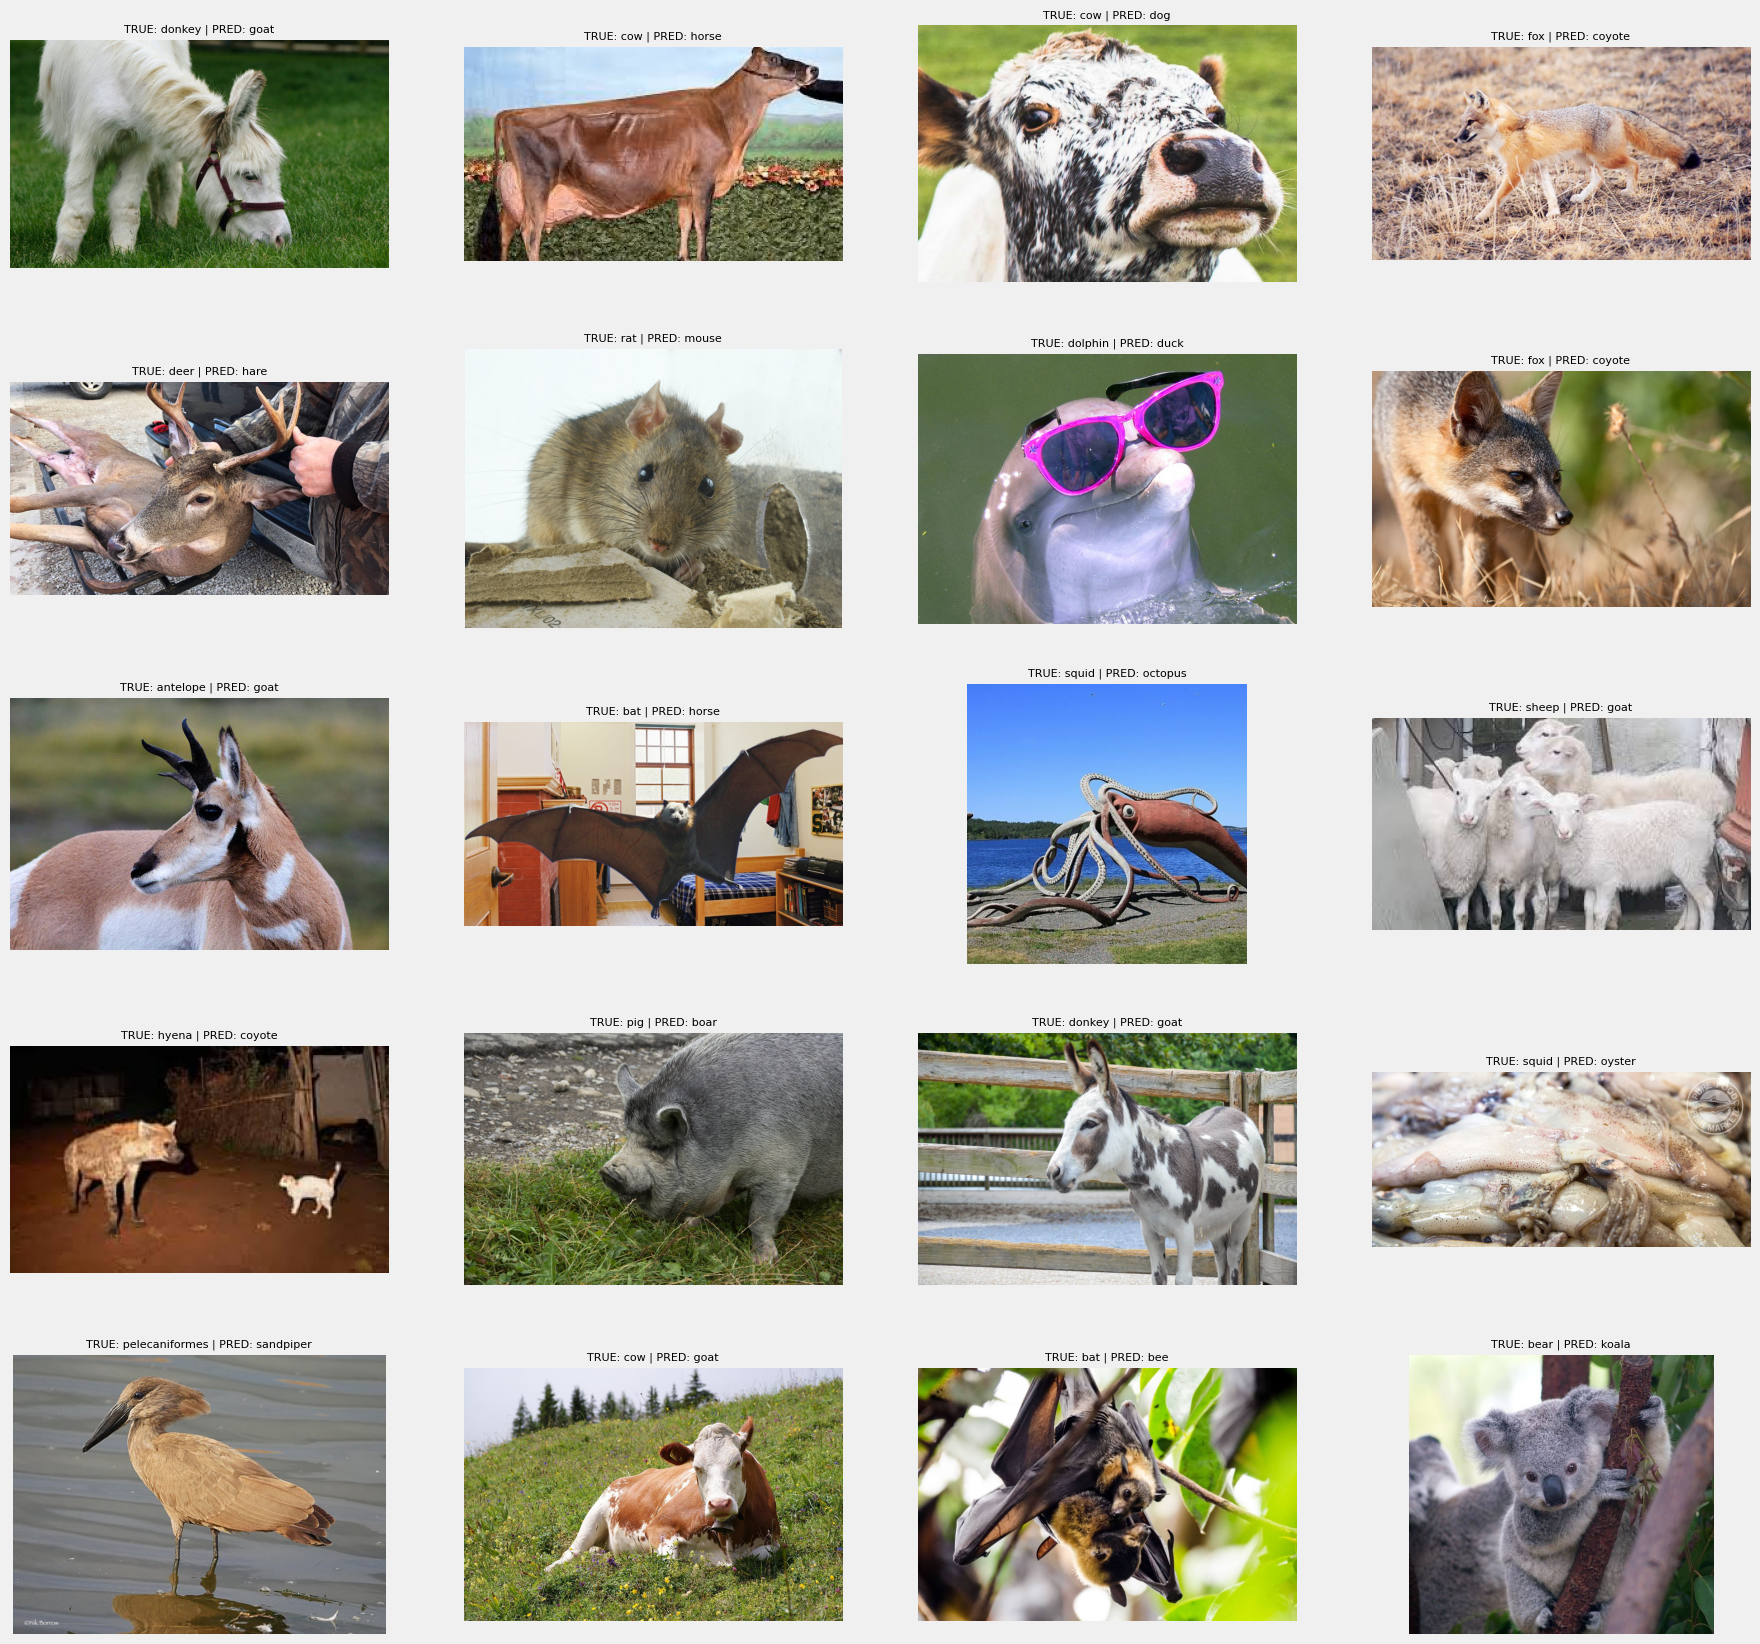

In [18]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')
    
plt.show()

แสดงภาพตัวอย่าง 20 ภาพจากชุดข้อมูลการทดสอบ ซึ่งเป็นภาพที่มีการทำนายที่ผิด โดยใช้ matplotlib

## 65050106 นายคุณานนต์ ลิ้มวัฒนาภรณ์